# 호텔 노쇼 고객 예측 분석

2023.12.16 ~ 2024.01.07

---

## 1. 프로젝트 개요

### 1-1. 프로젝트 요약
- 제목: 호텔 노쇼 고객 예측 분석
- 설명: 호텔 투숙객들의 예약 데이터로부터 노쇼 고객을 식별할 방법을 발견하고, 이를 방지할 액션 아이템 도출
- 사용한 데이터셋
    - [Hotel Bookings Analysis](https://www.kaggle.com/datasets/thedevastator/hotel-bookings-analysis): 호텔 예약, 취소 및 투숙객 세부 정보에 대한 포괄적인 데이터셋
- 진행 절차 및 내용
    - 데이터 로딩, 컬럼별 EDA, 상관관계 확인
    - 데이터 전처리, 노쇼에 대한 **분류 모델** 생성, 하이퍼 파라미터 튜닝
    - 컬럼 간 중요도 도출, 영향력 높은 컬럼의 **의존성 플롯** 확인
- 사용한 스킬셋
    - pandas, numpy
    - matplotlib, seaborn
    - scikit-learn
    - pdpbox

---

## 2. 데이터 로딩 및 EDA

### 2-1. 데이터 불러오기

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.inspection import PartialDependenceDisplay

In [2]:
hotel_df = pd.read_csv('hotel_bookings.csv', index_col='index')
hotel_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
index,,,,,,,,,,,,,,,,,,,,,
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,02-07-15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,02-07-15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,03-07-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,06-09-17
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,07-09-17
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,07-09-17


In [3]:
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
hotel_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

|컬럼명|설명|
|:---:|:---|
|hotel|호텔의 종류 (Categorical)|
|is_canceled|예약 취소 여부 (Binary)|
|lead_time|예약일과 도착일 사이의 일수 (Numeric)|
|arrival_date_year|도착일 연도 (Numeric)|
|arrival_date_month|도착일 월 (Categorical)|
|arrival_date_week_number|도착일 주 (Numeric)|
|arrival_date_day_of_month|도착일 일 (Numeric)|
|stays_in_weekend_nights|호텔에 투숙하거나 예약한 주말 밤의 수 (Numeric)|
|stays_in_week_nights|호텔에 투숙하거나 예약한 주박 수 (Numeric)|
|adults, children, babies|연령대별 투숙객수|
|meal|예약 패키지에 포함된 식사 종류 (Categorical)|
|country & market_segment & distribution_channel|인구통계학적 및 고객 분류 정보|
|is_repeated_guest|반복 방문자 여부|
|previous_cancellations|이전 예약을 취소한 횟수|
|previous_bookings_not_canceled|취소하지 않은 이전 예약 수|
|reserved_room_type|원래 예약된 유형의 객실|
|assigned_room_type|최종적으로 할당된 객실 유형|
|booking_changes|도착 전 예약 변경 횟수|
|deposit_type|예약을 위해 입금된 유형 (Categorical)|
|agent & company|예약에 관련된 여행사 & 회사|
|days_in_waiting_list|예약이 확인 또는 취소되기 전 대기 목록에 있었던 일수|
|customer_type|고객 유형 정보 (Categorical)|
|adr|객실당 일평균 요금(전체 비용/숙박 일수) (Numeric)|

### 2-2. 데이터 분포 확인 및 전처리

#### 2-2-1. 호텔 종류

In [5]:
hotel_df['hotel'].value_counts().to_frame()

,hotel
City Hotel,79330
Resort Hotel,40060


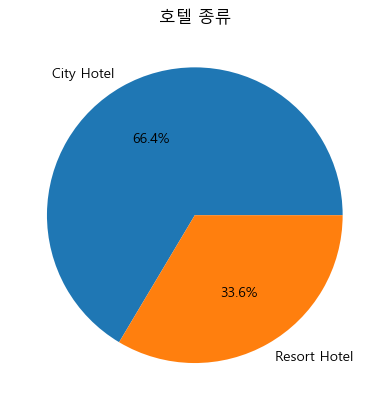

In [6]:
plt.pie(
    hotel_df['hotel'].value_counts(),
    labels=hotel_df['hotel'].value_counts().index,
    autopct="%.1f%%"
)
plt.title('호텔 종류')
plt.show()

City Hotel이 많다.

현재 범주형으로 들어가 있기 때문에 정수형으로 변환해 줄 필요가 있다.

In [7]:
hotels = list(hotel_df['hotel'].value_counts().index)
hotel_df['hotel_binary'] = hotel_df['hotel'].apply(lambda x:hotels.index(x))
hotel_df[['hotel', 'hotel_binary']].value_counts()

hotel         hotel_binary
City Hotel    0               79330
Resort Hotel  1               40060
dtype: int64

#### 2-2-2. 예약 취소 및 노쇼

In [8]:
hotel_df['is_canceled'].value_counts().to_frame()

,is_canceled
0,75166
1,44224


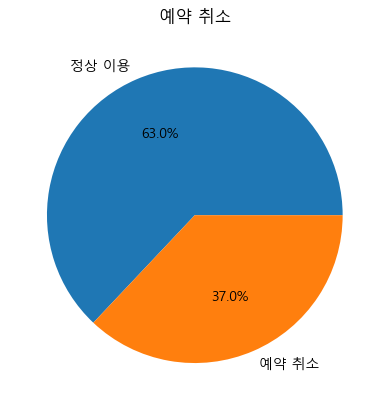

In [9]:
plt.pie(
    hotel_df['is_canceled'].value_counts(),
    labels=hotel_df['is_canceled'].value_counts().index.map({0: '정상 이용', 1: '예약 취소'}),
    autopct="%.1f%%"
)
plt.title('예약 취소')
plt.show()

생각보다 예약 취소한 비율이 많다.

In [10]:
hotel_df['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [11]:
hotel_df[['reservation_status', 'is_canceled']].value_counts()

reservation_status  is_canceled
Check-Out           0              75166
Canceled            1              43017
No-Show             1               1207
dtype: int64

예약 취소에는 취소와 노쇼가 모두 포함되어 있다.

In [12]:
hotel_df['is_no_show'] = hotel_df['reservation_status'].apply(lambda x:1 if x == 'No-Show' else 0)
hotel_df[['reservation_status', 'is_no_show']].value_counts()

reservation_status  is_no_show
Check-Out           0             75166
Canceled            0             43017
No-Show             1              1207
dtype: int64

노쇼인 경우만을 표시해 주는 파생 컬럼을 생성한다.

#### 2-1-3. 도착 일자

In [13]:
hotel_df['arrival_date_year'].value_counts().to_frame().reset_index().sort_values('index').reset_index(drop=True)

,index,arrival_date_year
0,2015,21996
1,2016,56707
2,2017,40687


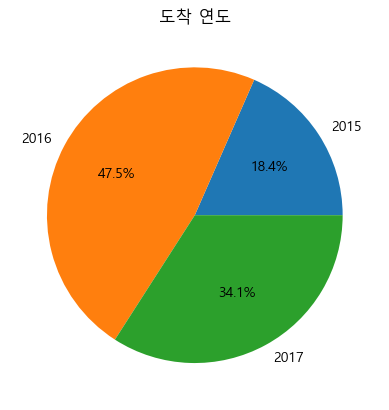

In [14]:
plt.pie(
    hotel_df['arrival_date_year'].value_counts().to_frame().reset_index().sort_values('index')['arrival_date_year'],
    labels=hotel_df['arrival_date_year'].value_counts().to_frame().reset_index().sort_values('index')['index'],
    autopct="%.1f%%"
)
plt.title('도착 연도')
plt.show()

2015~2017년의 분포이며 2016년 데이터가 가장 많다.

In [15]:
# 월별 집계
arrival_month_df = hotel_df['arrival_date_month'].value_counts().to_frame().reset_index()

# 월 순서에 따라 정렬
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
arrival_month_df['index'] = pd.Categorical(
    arrival_month_df['index'], categories=month_order, ordered=True
)
sorted_arrival_month_df = arrival_month_df.sort_values('index').reset_index(drop=True)

sorted_arrival_month_df

,index,arrival_date_month
0,January,5929
1,February,8068
2,March,9794
3,April,11089
4,May,11791
5,June,10939
6,July,12661
7,August,13877
8,September,10508
9,October,11160


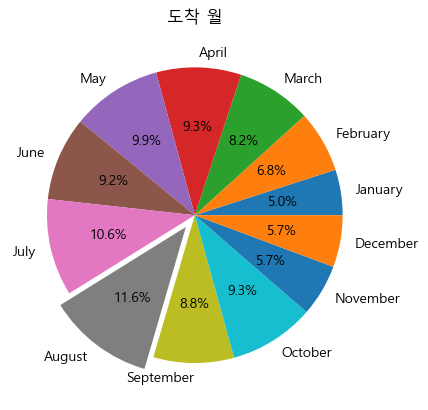

In [16]:
max_index = sorted_arrival_month_df[
    sorted_arrival_month_df['arrival_date_month'] == sorted_arrival_month_df['arrival_date_month'].max()
].index[0]

plt.pie(
    sorted_arrival_month_df['arrival_date_month'],
    explode=[0.1 if i == max_index else 0 for i in range(len(sorted_arrival_month_df))],
    labels=sorted_arrival_month_df['index'],
    autopct="%.1f%%"
)

plt.title('도착 월')
plt.show()

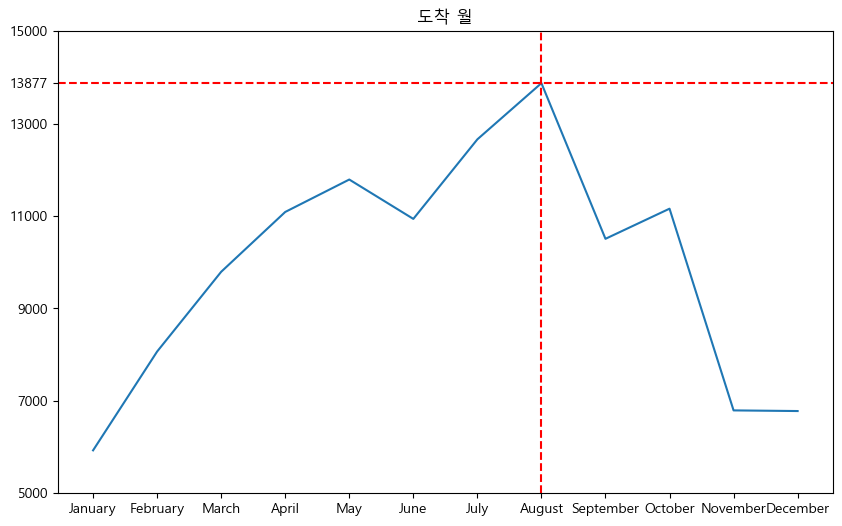

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    'index', 'arrival_date_month', data=sorted_arrival_month_df
)

plt.title('도착 월')
plt.axhline(sorted_arrival_month_df['arrival_date_month'].max(), linestyle='--', color='red')
plt.axvline(max_index, linestyle='--', color='red')
plt.yticks([i for i in range(5000, 15001, 2000)] + [sorted_arrival_month_df['arrival_date_month'].max()])

plt.show()

**8월**이 가장 많고 전반적으로 여름 휴가철이 많은 편에 속한다. 반면 겨울철은 여름철의 절반 수준으로 낮다.

도착 월도 범주형으로 들어가 있기 때문에 정수형으로 변환해 준다.

In [18]:
hotel_df['arrival_month_binary'] = hotel_df['arrival_date_month'].apply(lambda x:month_order.index(x) + 1)
hotel_df[['arrival_month_binary', 'arrival_date_month']].value_counts(sort=False)

arrival_month_binary  arrival_date_month
1                     January                5929
2                     February               8068
3                     March                  9794
4                     April                 11089
5                     May                   11791
6                     June                  10939
7                     July                  12661
8                     August                13877
9                     September             10508
10                    October               11160
11                    November               6794
12                    December               6780
dtype: int64

#### 2-1-4. 예약 일정

In [19]:
hotel_df['lead_time'].describe()

count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64

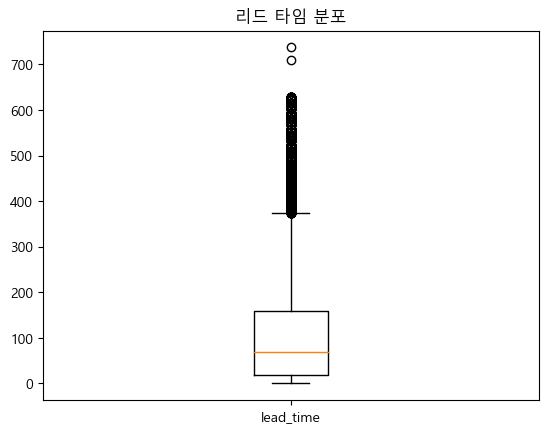

In [20]:
plt.boxplot(hotel_df['lead_time'], labels=['lead_time'])
plt.title('리드 타임 분포')
plt.show()

일반적으로 방문하기 **18일 ~ 160일 전**에 예약하는 것으로 확인된다. 당일 예약의 사례도 있고 737일(2년 전...?)의 사례도 있다.

In [21]:
hotel_df['stays_in_weekend_nights'].value_counts().to_frame().reset_index().sort_values('index').set_index('index')

,stays_in_weekend_nights
index,
0,51998
1,30626
2,33308
3,1259
4,1855
5,79
6,153
7,19
8,60


숙박 일정 중 주말 밤을 안 끼는 경우가 가장 많다. 최대값은 19번인데, 주말 밤을 19번이나 보냈다는 건 두 달 이상을 연속으로 투숙한 케이스로 이해할 수 있다.

In [22]:
hotel_df['stays_in_week_nights'].value_counts().to_frame().reset_index().sort_values('index').set_index('index')

,stays_in_week_nights
index,
0,7645
1,30310
2,33684
3,22258
4,9563
5,11077
6,1499
7,1029
8,656


평일의 경우 1박 ~ 3박의 케이스가 가장 많다.

근데 총 몇 박인지를 설명하는 컬럼이 없네? 파생 컬럼을 하나 만들어 주는 게 좋겠다.

In [23]:
hotel_df['stays_in_every_nights'] = hotel_df['stays_in_weekend_nights'] + hotel_df['stays_in_week_nights']
hotel_df[['stays_in_weekend_nights', 'stays_in_week_nights', 'stays_in_every_nights']]

,stays_in_weekend_nights,stays_in_week_nights,stays_in_every_nights
index,,,
0,0,0,0
1,0,0,0
2,0,1,1
3,0,1,1
4,0,2,2
...,...,...,...
119385,2,5,7
119386,2,5,7
119387,2,5,7


#### 2-2-5. 투숙객 연령대

In [24]:
hotel_df['adults'].value_counts().reset_index().sort_values('index').set_index('index')

,adults
index,
0,403
1,23027
2,89680
3,6202
4,62
5,2
6,1
10,1
20,2


투숙객의 경우 성인이 2명인 경우가 압도적으로 많다. 성인이 0명인 케이스와 55명(...?)인 케이스도 있다.

In [25]:
hotel_df['children'].value_counts().reset_index().sort_values('index').set_index('index')

,children
index,
0.0,110796
1.0,4861
2.0,3652
3.0,76
10.0,1


어린이는 0명인 경우가 가장 많다.

In [26]:
hotel_df['babies'].value_counts().reset_index().sort_values('index').set_index('index')

,babies
index,
0,118473
1,900
2,15
9,1
10,1


아기 역시 마찬가지다. 이상을 통해, **성인들끼리 방문하는 경우**가 가장 많음을 파악할 수 있다.

이제 전체 투숙객이 몇 명인지 나타내는 파생 컬럼도 있으면 좋을 것 같다.

In [27]:
hotel_df['guests'] = hotel_df['adults'] + hotel_df['children'] + hotel_df['babies']
hotel_df[['guests', 'adults', 'children', 'babies']]

,guests,adults,children,babies
index,,,,
0,2.0,2,0.0,0
1,2.0,2,0.0,0
2,1.0,1,0.0,0
3,1.0,1,0.0,0
4,2.0,2,0.0,0
...,...,...,...,...
119385,2.0,2,0.0,0
119386,3.0,3,0.0,0
119387,2.0,2,0.0,0


#### 2-2-6. 이전 예약

In [28]:
hotel_df['is_repeated_guest'].value_counts()

0    115580
1      3810
Name: is_repeated_guest, dtype: int64

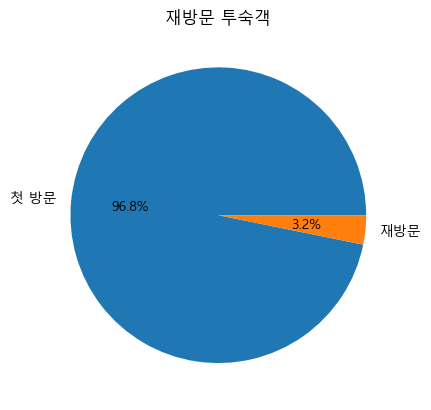

In [29]:
plt.pie(
    hotel_df['is_repeated_guest'].value_counts(),
    labels=hotel_df['is_repeated_guest'].value_counts().index.map({0: '첫 방문', 1: '재방문'}),
    autopct="%.1f%%"
)
plt.title('재방문 투숙객')
plt.show()

**첫 방문**인 투숙객이 압도적으로 많다.

In [30]:
hotel_df['previous_cancellations'].describe()

count    119390.000000
mean          0.087118
std           0.844336
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: previous_cancellations, dtype: float64

이전에 취소한 예약이 없는 투숙객이 압도적으로 많다. 당연하다. 첫 방문인 투숙객이 압도적으로 많으니까

In [31]:
hotel_df[hotel_df['is_repeated_guest'] == 1]['previous_cancellations'].describe()

count    3810.000000
mean        0.469816
std         1.440792
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        21.000000
Name: previous_cancellations, dtype: float64

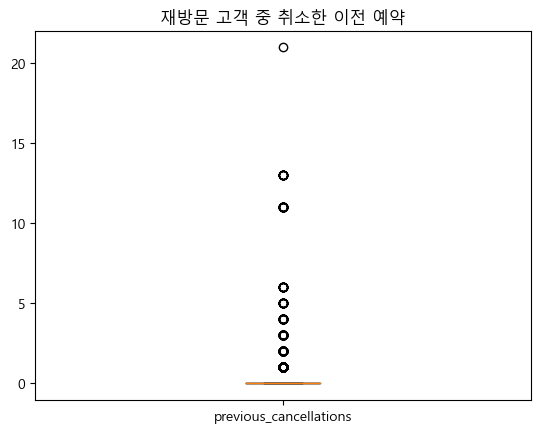

In [32]:
plt.boxplot(hotel_df[hotel_df['is_repeated_guest'] == 1]['previous_cancellations'], labels=['previous_cancellations'])
plt.title('재방문 고객 중 취소한 이전 예약')
plt.show()

재방문 고객 중에서 이전에 취소한 예약이 있는지 여부를 살펴봤는데 여전히 **0건**인 경우가 일반적이다.

In [33]:
hotel_df[hotel_df['is_repeated_guest'] == 1]['previous_bookings_not_canceled'].describe()

count    3810.000000
mean        3.585039
std         7.115979
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        72.000000
Name: previous_bookings_not_canceled, dtype: float64

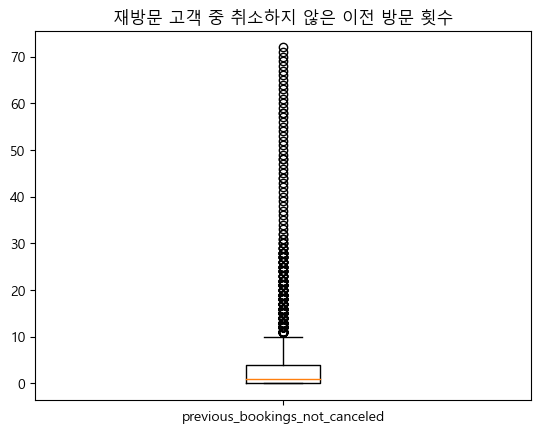

In [34]:
plt.boxplot(hotel_df[hotel_df['is_repeated_guest'] == 1]['previous_bookings_not_canceled'], labels=['previous_bookings_not_canceled'])
plt.title('재방문 고객 중 취소하지 않은 이전 방문 횟수')
plt.show()

비슷한 방법으로 재방문 고객 중 취소하지 않은 이전 방문 횟수를 살펴봤다. 왜 0건이 있는지 잘은 모르겠지만(...) **0~4건**이 일반적이다.

#### 2-2-7. 방문 이전 예약 행태

In [35]:
hotel_df['booking_changes'].describe()

count    119390.000000
mean          0.221124
std           0.652306
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.000000
Name: booking_changes, dtype: float64

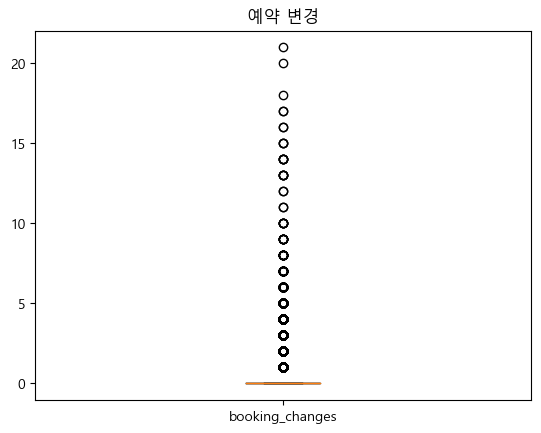

In [36]:
plt.boxplot(hotel_df['booking_changes'], labels=['booking_changes'])
plt.title('예약 변경')
plt.show()

방문 이전에 예약을 변경한 케이스를 살펴봤는데 **0건**이 일반적이다.

In [37]:
hotel_df['days_in_waiting_list'].describe()

count    119390.000000
mean          2.321149
std          17.594721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         391.000000
Name: days_in_waiting_list, dtype: float64

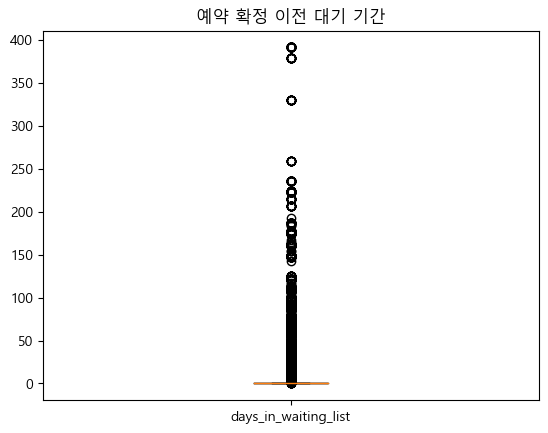

In [38]:
plt.boxplot(hotel_df['days_in_waiting_list'], labels=['days_in_waiting_list'])
plt.title('예약 확정 이전 대기 기간')
plt.show()

예약 확정 이전 대기 목록에 있던 기간도 **0일**이 일반적인 케이스다.

#### 2-2-8. 결제 금액

In [39]:
hotel_df['adr'].describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

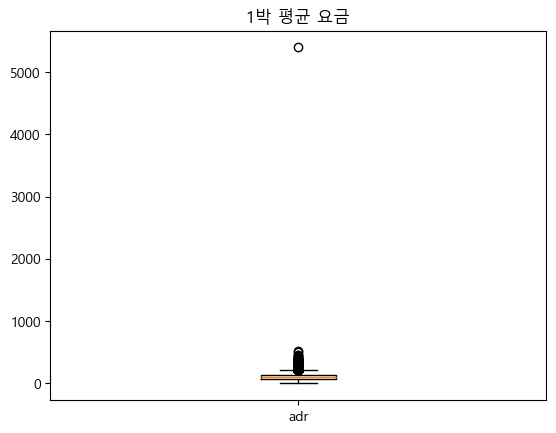

In [40]:
plt.boxplot(hotel_df['adr'], labels=['adr'])
plt.title('1박 평균 요금')
plt.show()

1박 평균 요금은 **69달러 ~ 126달러**가 일반적이다.

여기서 총 결제 금액 컬럼을 만들어 두면 좋을 것 같다.

In [41]:
hotel_df['total_price'] = hotel_df['adr'] * hotel_df['stays_in_every_nights']
hotel_df[['adr', 'stays_in_every_nights', 'total_price']]

,adr,stays_in_every_nights,total_price
index,,,
0,0.00,0,0.00
1,0.00,0,0.00
2,75.00,1,75.00
3,75.00,1,75.00
4,98.00,2,196.00
...,...,...,...
119385,96.14,7,672.98
119386,225.43,7,1578.01
119387,157.71,7,1103.97


### 2-3. 상관관계 확인

In [42]:
corr_df = np.abs(hotel_df.corr())
corr_df

C:\Users\louis\AppData\Local\Temp\ipykernel_12256\1066587922.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = np.abs(hotel_df.corr())


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_binary,is_no_show,arrival_month_binary,stays_in_every_nights,guests,total_price
is_canceled,1.000000,0.293123,0.016660,0.008148,0.006130,0.001791,0.024765,0.060017,0.005048,0.032491,...,0.054186,0.047557,0.195498,0.234658,0.136531,0.131752,0.011022,0.017779,0.046506,0.046562
lead_time,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,0.037622,0.020915,...,0.170084,0.063077,0.116451,0.095712,0.075381,0.044286,0.131424,0.157167,0.072279,0.086778
arrival_date_year,0.016660,0.040142,1.000000,0.540561,0.000221,0.021497,0.030883,0.029635,0.054624,0.013192,...,0.056497,0.197580,0.013684,0.108531,0.035267,0.003782,0.527739,0.031438,0.052152,0.124350
arrival_date_week_number,0.008148,0.126871,0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005518,0.010395,...,0.022933,0.075791,0.001920,0.026149,0.001270,0.023591,0.995105,0.018719,0.025216,0.059243
arrival_date_day_of_month,0.006130,0.002268,0.000221,0.066809,1.000000,0.016354,0.028174,0.001566,0.014544,0.000230,...,0.022728,0.030245,0.008683,0.003062,0.001862,0.013717,0.026063,0.027408,0.006758,0.002528
stays_in_weekend_nights,0.001791,0.085671,0.021497,0.018208,0.016354,1.000000,0.498969,0.091871,0.045793,0.018483,...,0.054151,0.049342,0.018554,0.072671,0.186596,0.016969,0.018440,0.762790,0.101439,0.572201
stays_in_week_nights,0.024765,0.165799,0.030883,0.015558,0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,...,0.002020,0.065237,0.024859,0.068192,0.234020,0.006017,0.019212,0.941005,0.101670,0.703020
adults,0.060017,0.119519,0.029635,0.025909,0.001566,0.091871,0.092976,1.000000,0.030447,0.018146,...,0.008283,0.230641,0.014785,0.122884,0.013183,0.033777,0.028534,0.105249,0.821102,0.193601
children,0.005048,0.037622,0.054624,0.005518,0.014544,0.045793,0.044203,0.030447,1.000000,0.024030,...,0.033273,0.324854,0.056253,0.081745,0.044205,0.003698,0.005441,0.050864,0.579373,0.232072
babies,0.032491,0.020915,0.013192,0.010395,0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,...,0.010621,0.029186,0.037383,0.097889,0.043434,0.001370,0.010172,0.022283,0.162690,0.037839


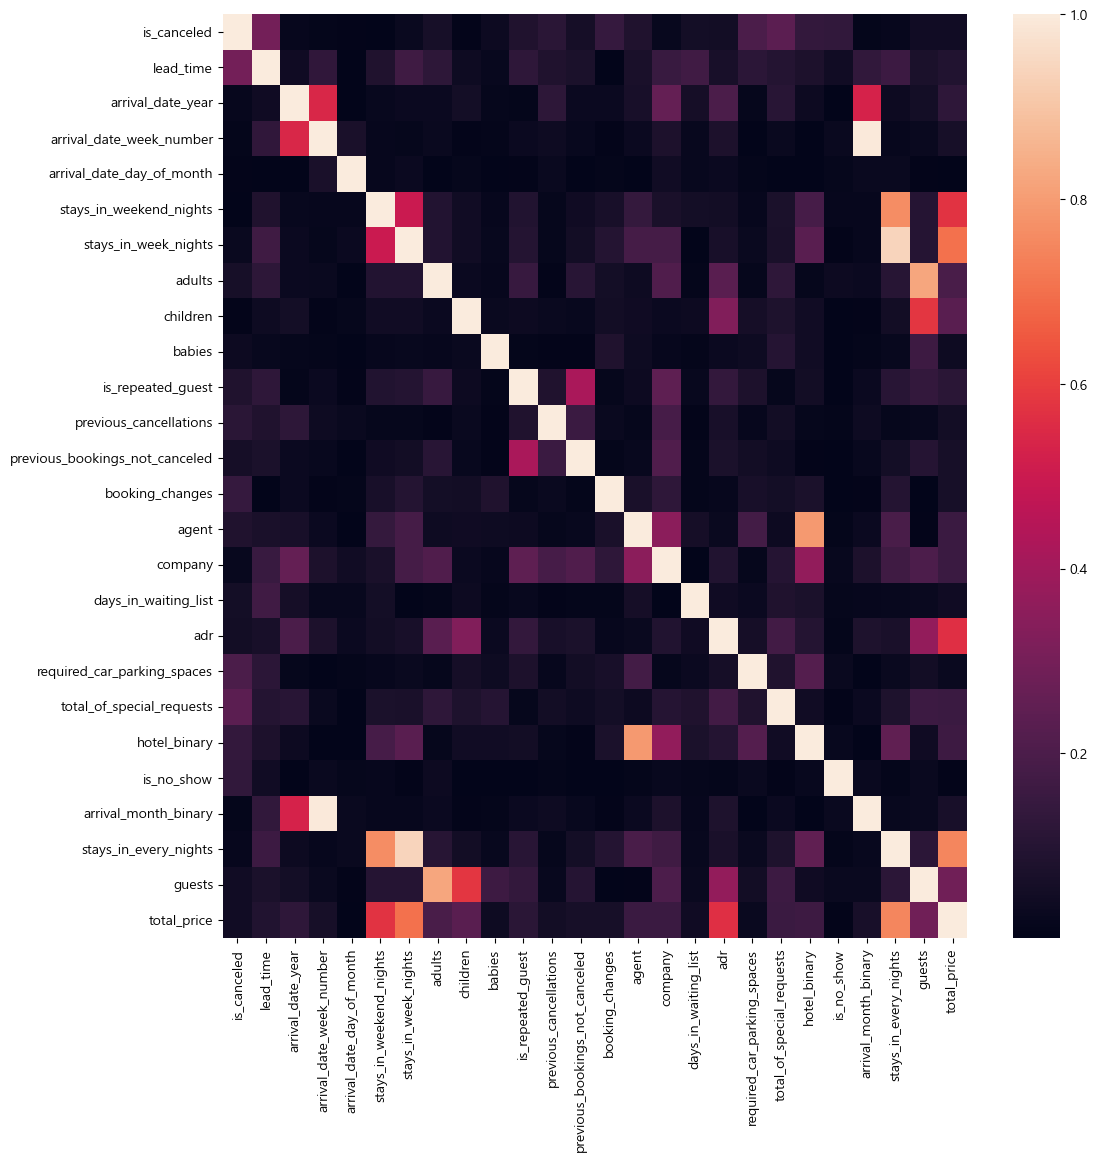

In [43]:
plt.figure(figsize=(12, 12))
sns.heatmap(np.abs(corr_df))
plt.show()

컬럼이 굉장히 많은 것에 비해 대부분이 시커멓기 때문에, 상관관계가 0.5 이상인 것들만 살펴보면 좋을 것 같다.

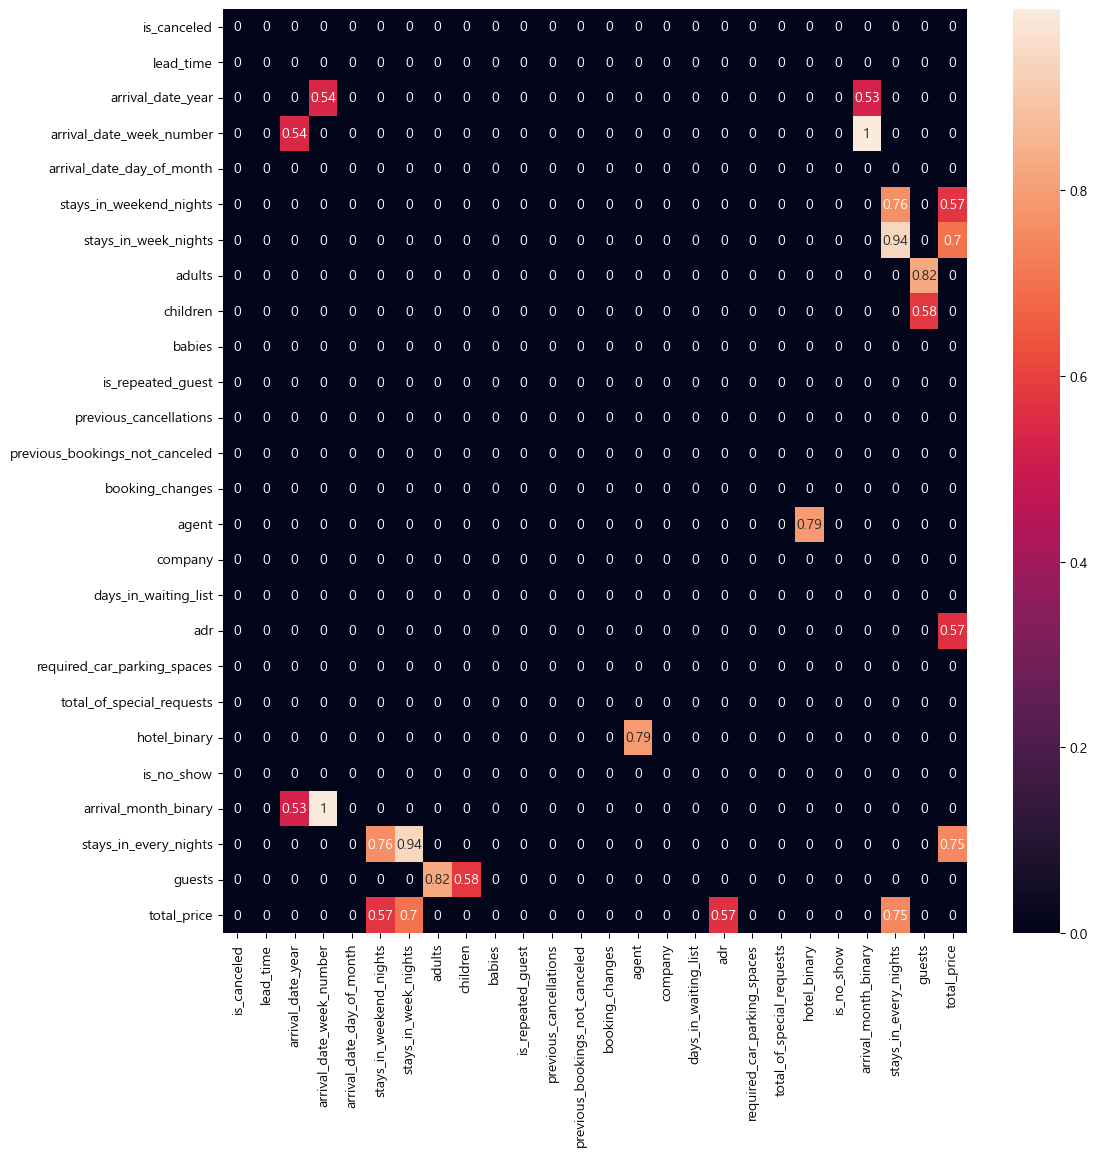

In [44]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_df[(corr_df >= 0.5) & (corr_df < 1)].fillna(0),
    annot=True
)
plt.show()

당연히 선형 관계가 있어야만 하는 컬럼들 제외하면 딱히 눈에 띄는 게 없다.

In [45]:
# pickle로 저장
with open('hotel_df.pkl', 'wb') as file:
    pickle.dump(hotel_df, file)

---

## 3. 데이터 분석

### 3-1. 문제 정의

초특가(25)씨는 숙박업체 예약 전문 앱을 운영하는 '자놀자'에서 데이터 분석가로 재직하는 중이다. 자놀자는 현재 이용객의 노쇼 문제로 고민이 이만저만이 아니다. 자놀자는 숙박 중개업자로서 노쇼 비용의 일부를 영업장에 부담해야 하기 때문이다. 또한 노쇼 고객으로 인해 수익의 기회가 상실된다는 점도 자놀자의 비즈니스에 부정적인 요인이다.

특가씨는 자놀자의 영업이익 제고와 원활한 운영을 위해 **노쇼 위험 고객**을 미리 식별할 방법을 구상하고자 한다. 지금부터 특가씨의 입장에서, 데이터 분석 방법론을 적용하여 이탈 고객을 예측하는 프로젝트를 진행한다.

분석 flow는 다음과 같다.
- 분석에 투입할 컬럼 선정
- y = ```is_canceled```에 대한 분류 모델 생성
- 결과 해석하여 노쇼 의심 고객의 특성을 식별
- 비즈니스적인 액션 아이템 도출

### 3-2. 데이터 전처리

#### 3-2-1. 데이터 로딩 및 컬럼 선정

In [46]:
with open('hotel_df.pkl', 'rb') as file:
    hotel_df = pickle.load(file)

In [47]:
hotel_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,hotel_binary,is_no_show,arrival_month_binary,stays_in_every_nights,guests,total_price
index,,,,,,,,,,,,,,,,,,,,,
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Check-Out,01-07-15,1,0,7,0,2.0,0.00
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,Check-Out,01-07-15,1,0,7,0,2.0,0.00
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,Check-Out,02-07-15,1,0,7,1,1.0,75.00
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,Check-Out,02-07-15,1,0,7,1,1.0,75.00
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,1,Check-Out,03-07-15,1,0,7,2,2.0,196.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,Check-Out,06-09-17,0,0,8,7,2.0,672.98
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,2,Check-Out,07-09-17,0,0,8,7,3.0,1578.01
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,4,Check-Out,07-09-17,0,0,8,7,2.0,1103.97


우선 카테고리컬 변수들은 정수형 파생 컬럼을 생성했거나 분석 대상에서 제외했기 때문에 모두 drop해줘도 상관없다.

In [48]:
hotel_df_dropped = hotel_df.select_dtypes(exclude=['object'])
hotel_df_dropped

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_binary,is_no_show,arrival_month_binary,stays_in_every_nights,guests,total_price
index,,,,,,,,,,,,,,,,,,,,,
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,0.00,0,0,1,0,7,0,2.0,0.00
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0.00,0,0,1,0,7,0,2.0,0.00
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,75.00,0,0,1,0,7,1,1.0,75.00
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,75.00,0,0,1,0,7,1,1.0,75.00
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,98.00,0,1,1,0,7,2,2.0,196.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,...,0,96.14,0,0,0,0,8,7,2.0,672.98
119386,0,102,2017,35,31,2,5,3,0.0,0,...,0,225.43,0,2,0,0,8,7,3.0,1578.01
119387,0,34,2017,35,31,2,5,2,0.0,0,...,0,157.71,0,4,0,0,8,7,2.0,1103.97


분석에 투입할 컬럼 선택을 위해 다시 히트맵을 그려 본다.

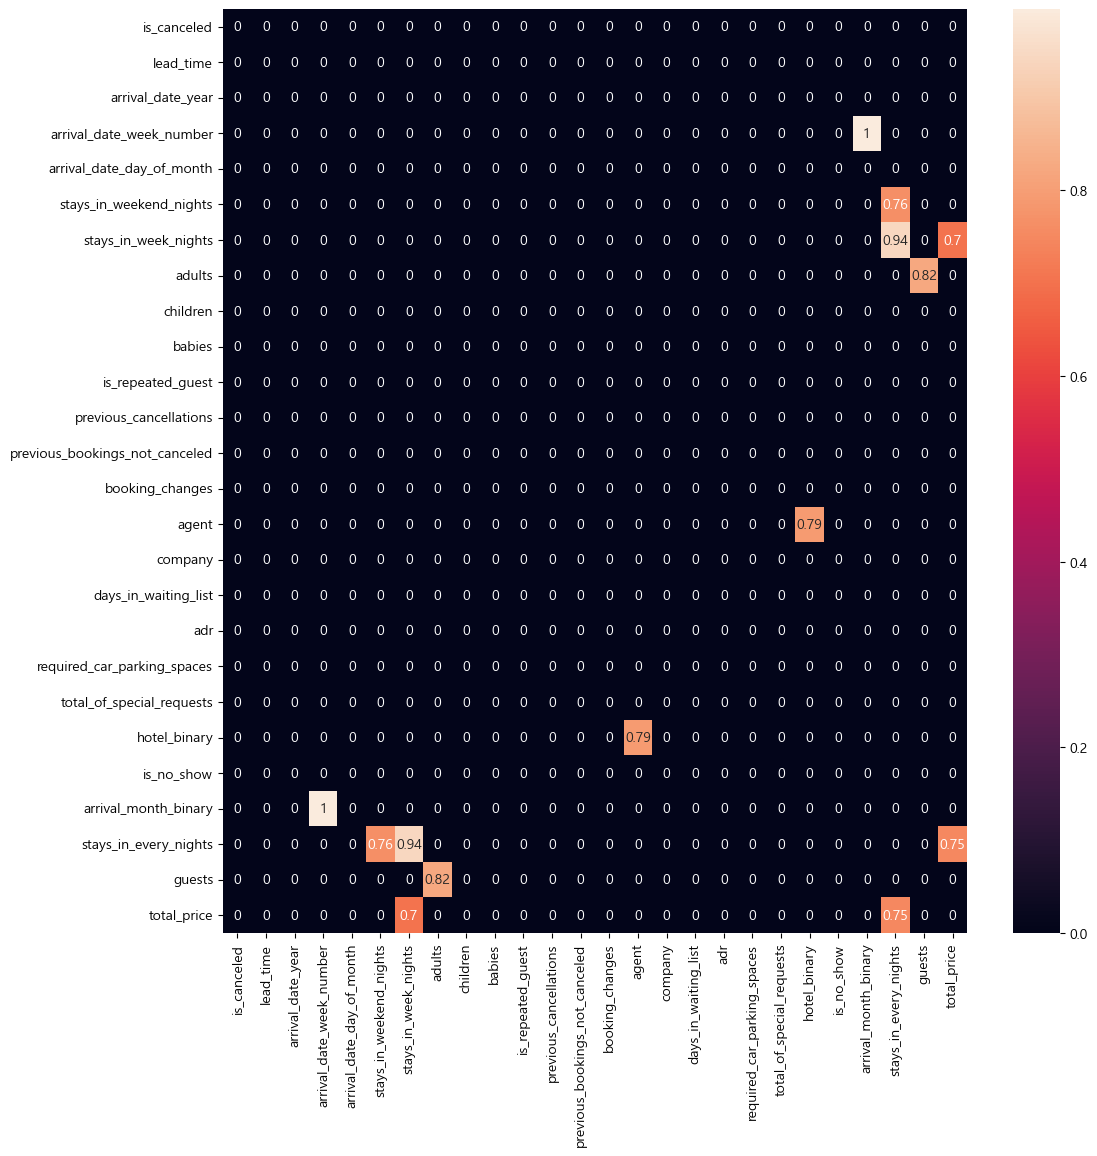

In [49]:
corr_df = np.abs(hotel_df_dropped.corr())

plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_df[(corr_df >= 0.7) & (corr_df < 1)].fillna(0),
    annot=True
)
plt.show()

다중공선성 및 분석 목적을 고려하여 제거할 컬럼을 선별한다.

- ```is_canceled```: 이 컬럼은 '취소'와 '노쇼'를 모두 담고 있기 때문에, 노쇼 고객을 식별하는 본 프로젝트에 적합하지 않다.
- ```arrival_date_year```, ```arrival_date_week_number```, ```arrival_date_day_of_month```: 어떤 날짜에 방문했는지는 크게 중요하지 않을 것으로 보인다. 다만 계절감을 반영하려면 방문 월은 남겨두는 게 좋겠다.
- ```stays_in_weekend_nights```, ```stays_in_week_nights```: 이미 두 요소를 대표하는 컬럼을 만들었기 때문에 굳이 필요하지 않다.
- ```adults```, ```children```, ```babies```: 이미 세 요소를 대표하는 컬럼을 만들었기 때문에 굳이 필요하지 않다.
- ```agent```, ```company```: 이미 분석 대상에서 제외한 컬럼이다.
- ```total_price```: 파생 컬럼 대신 기존에 존재하던 컬럼들을 활용하는 게 낫겠다.

In [50]:
drop_cols = [
    'is_canceled', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',
    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'agent', 'company', 'total_price'
]

hotel_df_dropped_dropped = hotel_df_dropped.drop(drop_cols, axis=1).dropna()
hotel_df_dropped_dropped

,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_binary,is_no_show,arrival_month_binary,stays_in_every_nights,guests
index,,,,,,,,,,,,,,
0,342,0,0,0,3,0,0.00,0,0,1,0,7,0,2.0
1,737,0,0,0,4,0,0.00,0,0,1,0,7,0,2.0
2,7,0,0,0,0,0,75.00,0,0,1,0,7,1,1.0
3,13,0,0,0,0,0,75.00,0,0,1,0,7,1,1.0
4,14,0,0,0,0,0,98.00,0,1,1,0,7,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,0,0,0,0,0,96.14,0,0,0,0,8,7,2.0
119386,102,0,0,0,0,0,225.43,0,2,0,0,8,7,3.0
119387,34,0,0,0,0,0,157.71,0,4,0,0,8,7,2.0


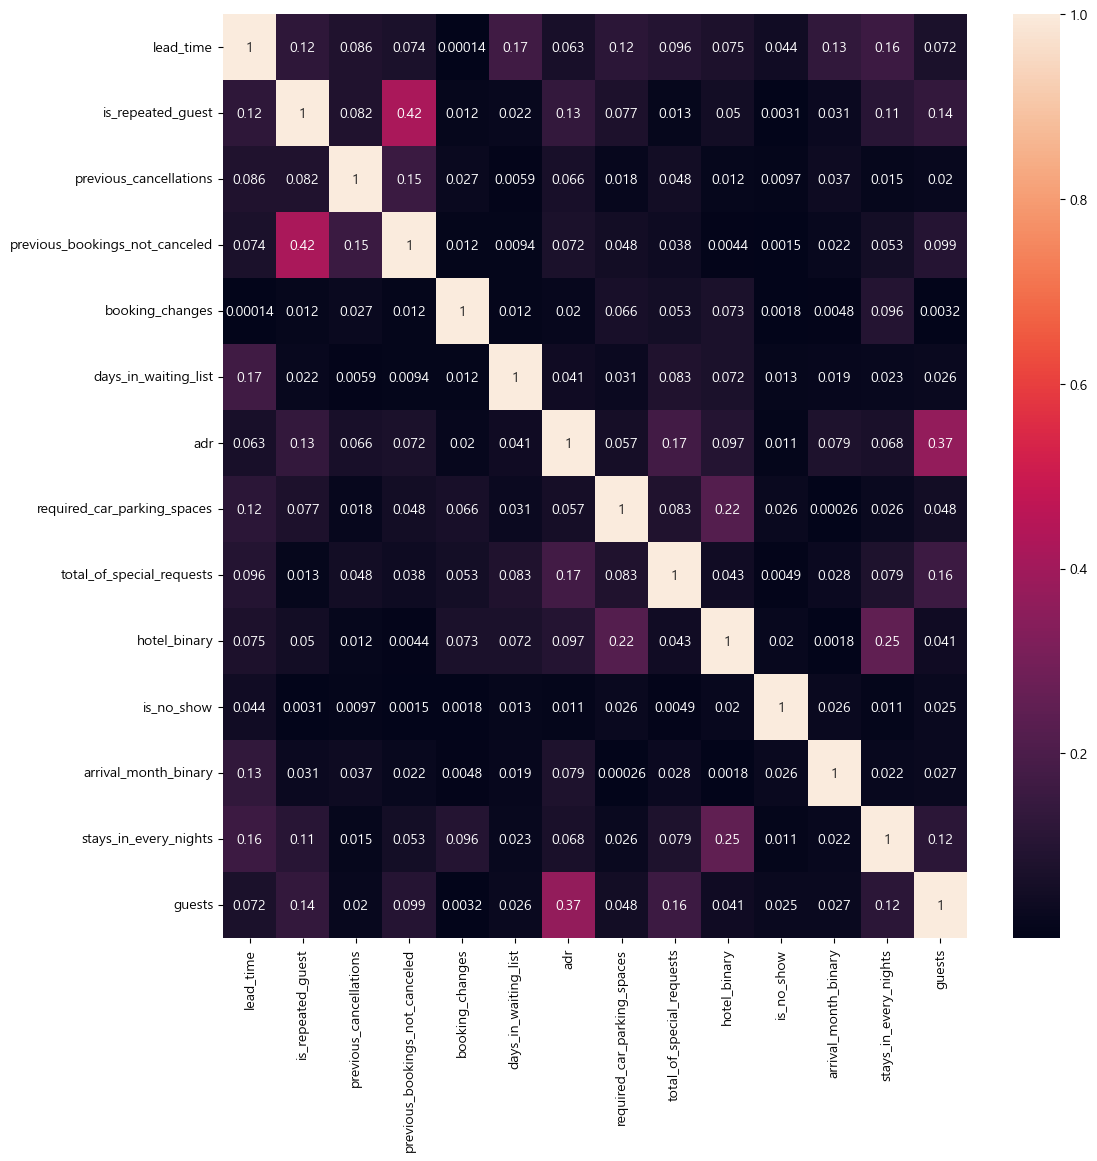

In [51]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    np.abs(hotel_df_dropped_dropped.corr()),
    annot=True
)
plt.show()

In [52]:
X = hotel_df_dropped_dropped.drop('is_no_show', axis=1)
y = hotel_df_dropped_dropped['is_no_show']

X.shape, y.shape

((119386, 13), (119386,))

#### 3-2-2. 데이터 표준화

In [53]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(119386, 13)

#### 3-2-3. 데이터 스플릿

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95508, 13), (23878, 13), (95508,), (23878,))

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((71631, 13), (23877, 13), (71631,), (23877,))

### 3-3. 분류 모델 생성

#### 3-3-1. 모델 선정

In [56]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC()
}

model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    model_results[name] = accuracy
    print(f"{name} 학습 완료! 성능: {accuracy}")

LogisticRegression 학습 완료! 성능: 1
DecisionTree 학습 완료! 성능: 1
RandomForest 학습 완료! 성능: 1
SVM 학습 완료! 성능: 1


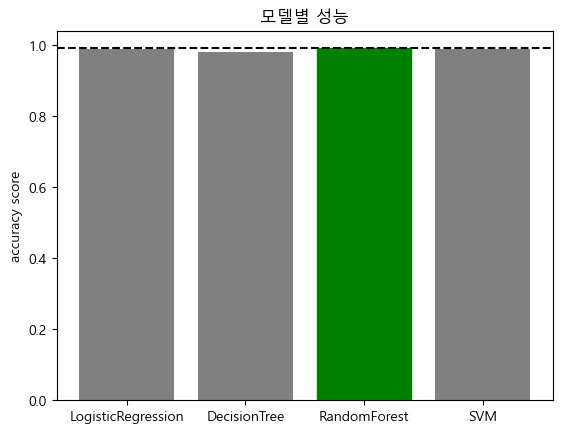

In [57]:
bars = plt.bar(
    model_results.keys(),
    model_results.values(),
    color='gray'
)

bars[list(model_results.values()).index(max(model_results.values()))].set_color('green')
plt.title('모델별 성능')
plt.ylabel('accuracy score')
plt.axhline(max(model_results.values()), color='black', linestyle='--')
plt.show()

거기서 거기 같기는 하지만 **랜덤 포레스트**의 성능이 가장 좋아보인다.

#### 3-3-2. 하이퍼 파라미터 튜닝

In [58]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}


In [59]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"모델 정확도: {accuracy}")

모델 정확도: 0.9910792813167484


#### 3-3-3. 컬럼 중요도 도출

In [63]:
importances = best_model.feature_importances_
importances_dict = dict(zip(
    hotel_df_dropped_dropped.drop('is_no_show', axis=1).columns,
    importances
))

importances_dict = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
for feature, importance in importances_dict:
    print(f"{feature}: {importance}")

adr: 0.3453682926017312
lead_time: 0.28593017315811037
stays_in_every_nights: 0.1135863500917394
arrival_month_binary: 0.11028035326202452
total_of_special_requests: 0.046501022335251226
guests: 0.03070227714027258
booking_changes: 0.02938733751154381
hotel_binary: 0.017757805476574073
previous_bookings_not_canceled: 0.009504529727975209
is_repeated_guest: 0.005835340202216518
required_car_parking_spaces: 0.002648280322424639
previous_cancellations: 0.0018373967590047885
days_in_waiting_list: 0.000660841411131588


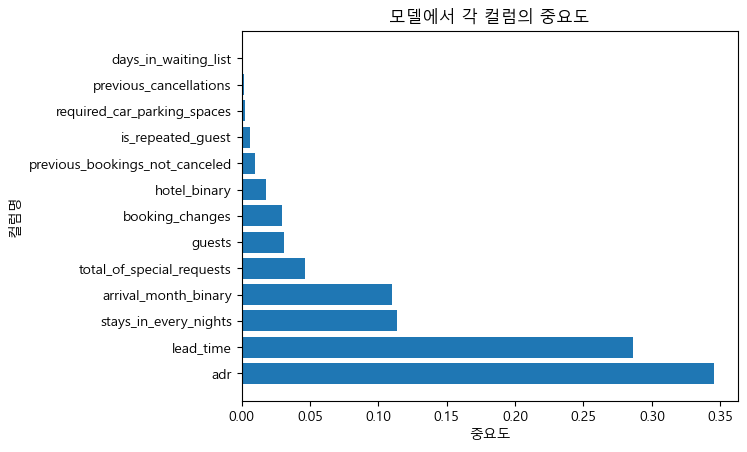

In [67]:
plt.barh(
    range(len(importances_dict)),
    [importance for feature, importance in importances_dict],
)

plt.yticks(range(len(importances_dict)), [feature for feature, importance in importances_dict])
plt.xlabel("중요도")
plt.ylabel("컬럼명")
plt.title("모델에서 각 컬럼의 중요도")
plt.show()

호텔 노쇼에는 **비용과 리드타임**이 가장 큰 영향을 미치는 것으로 분석되었다.

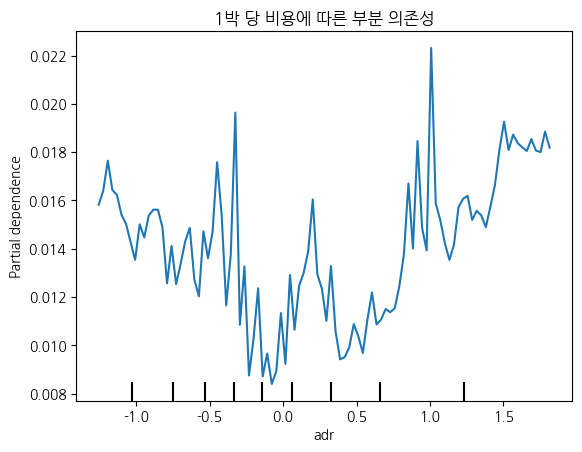

In [96]:
PartialDependenceDisplay.from_estimator(best_model, new_X, ['adr'])
plt.title('1박 당 비용에 따른 부분 의존성')
plt.show()

1박 당 비용이 너무 낮은 경우와 너무 높은 경우 호텔 노쇼가 더 많이 발생하는 경향을 보인다. 평균 근방에서 호텔 노쇼가 가장 적게 발생한다.

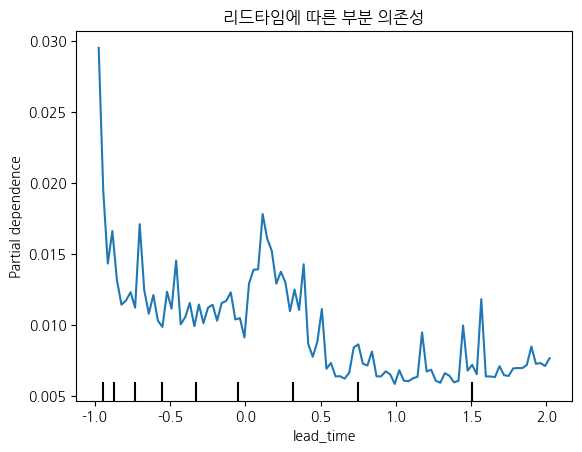

In [97]:
PartialDependenceDisplay.from_estimator(best_model, new_X, ['lead_time'])
plt.title('리드타임에 따른 부분 의존성')
plt.show()

리드타임은 길수록 노쇼가 발생하지 않는 경향을 보인다. 특히 리드타임이 극도로 짧은 경우에는 노쇼의 확률이 팍 튀는데, 신중하지 못하게 급한 예약을 잡아서 그런 게 아닐까 추측해 볼 수 있다.

리드타임이 길수록 '자놀자'에 유리하기 때문에, 초특가씨는 **얼리버드 쿠폰 발급**을 통해 유저들이 여유를 두고 숙박업소를 예약했을 때 혜택을 주도록 하는 방안을 고안했다.

---

## 4. 후기

ML 분류 모델을 통해 호텔 노쇼 예측을 진행해 보았다. 숙박업소 노쇼 고객 추이는 숙박 서비스 플랫폼에서의 KPI 중 하나로 간주될 가능성이 크다. 숙박 서비스 플랫폼 입장에서는 일반 유저들뿐만 아니라 숙박업소 역시 메인 고객이기 때문에, 고객 만족도를 높이는 방안을 다각도로 검토해야만 하기 때문이다. 뿐만 아니라 노쇼 비용의 일부를 플랫폼에서 부담해야 하는 경우도 있을 것이므로 cost를 줄인다는 의미에서도 중요하게 봐야 할 지표일 것이다.

다만 이런 결과로부터 어떤 액션 아이템을 도출해야 하는지에 대한 고민이 더 필요할 것으로 보인다. 1박 당 비용이 평균에 머무르고, 리드타임이 길수록 노쇼의 확률이 낮다는 점을 확인했는데, 그래서 플랫폼 입장에선 어떻게 해야 하는지 마땅히 떠올리기 어려웠다. 후자의 경우에는 그나마 얼리버드 쿠폰 발급과 같은 액션 아이템을 고안해 볼 수 있지만 전자의 경우에는 진짜 쉽지 않다. 숙박업소에서 책정한 비용을 플랫폼에서 조절하기란 불가능하기 때문이다.